<font size="2"> [github.com/jankoslavic/pypinm](http://github.com/jankoslavic/pypinm)</font>

[Prof. dr. Janko Slavič](http://www.ladisk.si/~slavic)

<center>
<img width=300 src="./fig/ladisk.png">
<br>
<font size="7" color="f00e0e" face="garamond"><b>Aproksimacija</b></font>
<img src="">
<font size="2">September 2020</font>
</center>

<h1>Kazalo<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Uvod" data-toc-modified-id="Uvod-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Uvod</a></span></li><li><span><a href="#Metoda-najmanjših-kvadratov-za-linearno-funkcijo" data-toc-modified-id="Metoda-najmanjših-kvadratov-za-linearno-funkcijo-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Metoda najmanjših kvadratov za linearno funkcijo</a></span><ul class="toc-item"><li><span><a href="#Uporaba-psevdo-inverzne-matrike" data-toc-modified-id="Uporaba-psevdo-inverzne-matrike-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Uporaba psevdo inverzne matrike</a></span></li></ul></li><li><span><a href="#Metoda-najmanjših-kvadratov-za-poljubni-polinom" data-toc-modified-id="Metoda-najmanjših-kvadratov-za-poljubni-polinom-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Metoda najmanjših kvadratov za poljubni polinom</a></span><ul class="toc-item"><li><span><a href="#Numerični-zgled" data-toc-modified-id="Numerični-zgled-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Numerični zgled</a></span></li><li><span><a href="#Uporaba-numpy-za-aproksimacjo-s-polinomom" data-toc-modified-id="Uporaba-numpy-za-aproksimacjo-s-polinomom-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Uporaba <code>numpy</code> za aproksimacjo s polinomom</a></span></li></ul></li><li><span><a href="#Aproksimacija-s-poljubno-funkcijo" data-toc-modified-id="Aproksimacija-s-poljubno-funkcijo-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Aproksimacija s poljubno funkcijo</a></span><ul class="toc-item"><li><span><a href="#Aproksimacija-s-harmonsko-funkcijo" data-toc-modified-id="Aproksimacija-s-harmonsko-funkcijo-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Aproksimacija s harmonsko funkcijo</a></span></li></ul></li><li><span><a href="#Nekaj-vprašanj-za-razmislek!" data-toc-modified-id="Nekaj-vprašanj-za-razmislek!-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Nekaj vprašanj za razmislek!</a></span></li><li><span><a href="#Dodatno" data-toc-modified-id="Dodatno-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Dodatno</a></span><ul class="toc-item"><li><span><a href="#Aproksimacija-z-zlepki-in-uporabo-SciPy" data-toc-modified-id="Aproksimacija-z-zlepki-in-uporabo-SciPy-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Aproksimacija z zlepki in uporabo <code>SciPy</code></a></span></li></ul></li></ul></div>

# Uvod

V strojniški praksi se pogosto srečamo s tabelo podatkov, ki so lahko obremenjeni z merilnimi ali numeričnimi napakami.

Oglejmo si primer meritve (linearne) vzmeti ($x$ je raztezek, $y$ je pomerjena sila):

In [27]:
import numpy as np

x = np.array([0.1,  1.1, 2.05, 3.2, 3.9  ])
y = np.array([0.22, 18.15, 44.33, 75.59, 105.63])

Poglejmo si podatke na sliki, najprej uvozimo potrebne pakete:

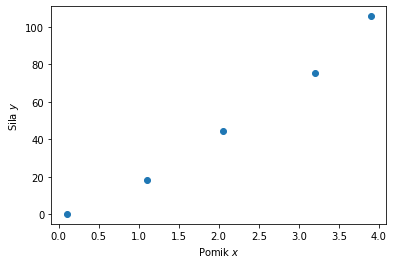

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(x, y, 'o');
plt.xlabel('Pomik $x$')
plt.ylabel('Sila $y$');

Za konkreten primer bi bilo, glede na poznavanje fizikalnega ozadja linearne vzmeti, primerno, da bi meritve poskušali popisati z linearno funkcijo:
$$f(x) = a_0\,x+ a_1$$

Poznamo tabelo $n$ podatkov $x_i, y_i$ za $i=0,1,\dots,n-1$; teh je več, kot jih potrebujemo za določitev dveh konstant $a_0$ in $a_1$, zato imamo torej predoločen sistem linearnih enačb: 

$$y_i=a_0\,x_i+a_1\quad\textrm{za}\quad i=0,1,\dots,n-1.$$

Iščemo taki vrednosti konstanti $a_0$ in $a_1$, da se bo funkcija $f(x)$ v znanih točkah $x_i$ *najbolje* ujemala z $y_i$.

Najprej torej potrebujemo kriterij za *najboljše* ujemanje. 

Za vrednosti iz tabele $x_i, y_i$ bi lahko iskali vrednosti $a_0$ in $a_1$, pri katerih bi bila vsota absolutne vrednosti odstopkov $S$ najmanjša:

$$P(a_0, a_1) = \sum_{i=0}^{n-1} |y_i - (a_0\,x_i+a_1)|.$$

Ker pa taka funkcija $P(a_0, a_1)$ ni zvezno odvedljiva,raje uporabimo **metodo najmanjših kvadratov**:

$$S(a_0, a_1) = \sum_{i=0}^{n-1} \left(y_i - (a_0\,x_i+a_1)\right)^2.$$

Takšna funkcija $S(a_0, a_1)$ je zvezna in zvezno odvedljiva. S parcialnim odvajanjem po parametrih $a_0$ in $a_1$ lahko najdemo stacionarno točko (parcialna odvoda sta enaka 0). Postopek si bomo za linearno funkcijo pogledali v naslednjem poglavju.

# Metoda najmanjših kvadratov za linearno funkcijo

Poiskati moramo konstanti $a_0$, $a_1$, da bo vsota kvadratov razlik med funkcijo in tabelirano vrednostjo ($x_i, y_i$, kjer $i=0,1,\dots, n-1$ in je $n$ število tabeliranih podatkov):

$$S(a_0, a_1) = \sum_{i=0}^{n-1} \left(y_i - (a_0\,x_i+a_1)\right)^2$$

najmanjša. Vrednost bo najmanjša v stacionarni točki, ki jo določimo s parcialnim odvodom po parametrih $a_0$ in $a_1$.

Najprej izvedemo parcialni odvod po parametru $a_0$:

$$\frac{\partial S(a_0, a_1)}{\partial a_0} = 2\,\sum_{i=0}^{n-1} \left(y_i - a_0\,x_i-a_1\right)\,(-x_i)$$

Izraz uredimo:

$$\frac{\partial S(a_0, a_1)}{\partial a_0} =-2\left(\sum_{i=0}^{n-1} y_i\,x_i -a_0\,\sum_{i=0}^{n-1} x_i^2- a_1\,\sum_{i=0}^{n-1} x_i\right)$$

Podobno postopamo še za $a_1$:

$$\frac{\partial S(a_0, a_1)}{\partial a_1} = 2\,\sum_{i=0}^{n-1} \left(y_i  - a_0\,x_i- a_1\right)\,(-1)$$

$$\frac{\partial S(a_0, a_1)}{\partial a_1} = -2\left(\sum_{i=0}^{n-1} y_i -a_0\,\sum_{i=0}^{n-1} x_i- a_1\,\sum_{i=0}^{n-1}1\right)$$

Ker v stacionarni točki velja $\partial S(a_0, a_1)/\partial a_0=0$ in $\partial S(a_0, a_1)/\partial a_1=0$, iz zgornjih izrazov izpeljemo:

$$a_0\,\sum_{i=0}^{n-1} x_i^2 + a_1\,\sum_{i=0}^{n-1} x_i=\sum_{i=0}^{n-1} y_i\,x_i$$

in

$$a_0\,\sum_{i=0}^{n-1} x_i+ a_1\,n=\sum_{i=0}^{n-1} y_i.$$

Dobili smo sistem dveh linearnih enačb za neznanki $a_0$ in $a_1$, ki ga znamo rešiti. Imenujemo ga *normalni sistem* (število enačb je enako številu neznank).

Zapišimo normalni sistem v matrični obliki:

In [29]:
A = [[np.sum(x**2), np.sum(x)], # matrika koeficientov
     [np.sum(x), len(x)]]
b = [np.dot(y,x), np.sum(y)]    # vektor konstant
A = np.asarray(A)
b = np.asarray(b)
print('A:', A)
print('b:', b)

A: [[30.8725 10.35  ]
 [10.35    5.    ]]
b: [764.7085 243.92  ]


Sedaj moramo rešiti linearni sistem:

$$\mathbf{A}\,\mathbf{a}=\mathbf{b},$$

Opomba, tukaj smo vektor neznank zapisali kot $\mathbf{a}=(a_0, a_1)$.

Sistem rešimo:

In [30]:
a0, a1 = np.linalg.solve(A, b)
a0, a1

(27.497258679085512, -8.135325465707014)

Preverimo še število pogojenosti:

In [31]:
np.linalg.cond(A)

25.20071350870242

Sedaj si bomo pogledali še rezultat. Najprej pripravimo sliko, ki bo vsebovala tudi informacijo o vsoti kvadratov odstopanja $f(x_i)$ od tabeliranih vrednosti $y_i$.

In [32]:
def slika(naklon=a0, premik=a1):
    d=1
    def linearna_f(x, a0, a1):
        return a0*x+a1
    def S(x, y, f):
        return np.sum(np.power(y-f,2))
    plt.plot(x,y,'.', label='Tabela podatkov')
    linearna_f1 = linearna_f(x, naklon, premik)
    linearna_f1_MNK = linearna_f(x, a0, a1)
    plt.plot(x, linearna_f1, '-', label='Izbrani parametri')
    plt.plot(x, linearna_f1_MNK, '-', label='Metoda najmanjših kvadratov')
    napaka = S(x, y, linearna_f(x, naklon, premik))
    sprememba_napake_v_smeri_a0 = (S(x, y, linearna_f(x, naklon+d, premik))-napaka)/d
    sprememba_napake_v_smeri_a1 = (S(x, y, linearna_f(x, naklon, premik+d))-napaka)/d
    title = f'S: {napaka:g}, \
            $\Delta S/\Delta a_0$: {sprememba_napake_v_smeri_a0:g}, \
            $\Delta S/\Delta a_1$: {sprememba_napake_v_smeri_a1:g}'
    plt.title(title)
    plt.legend()
    plt.ylim(-10,110)
    plt.show()

In [33]:
from ipywidgets import interact
interact(slika, naklon=(0, 50, 2), premik=(-10, 10, 1));

interactive(children=(IntSlider(value=27, description='naklon', max=50, step=2), IntSlider(value=-8, descripti…

## Uporaba psevdo inverzne matrike

Do podobnega rezultata lahko pridemo z uporabo psevdo inverzne matrike. Iščemo $y(x)=a_0\,x+a_1$ in nastavimo predoločen sistem $\mathbf{A}\,\mathbf{a}=\mathbf{y}$, kjer je matrika koeficientov $\mathbf{A}$ definirana glede na vrednosti $x_i$ ($i=0,1,\dots,n-1$):

In [34]:
A=np.array([x, np.ones_like(x)]).T
A

array([[0.1 , 1.  ],
       [1.1 , 1.  ],
       [2.05, 1.  ],
       [3.2 , 1.  ],
       [3.9 , 1.  ]])

Vektor konstant smo označili z $\mathbf{b}$, v našem primeru pa je to kar vektor vrednosti $\mathbf{y}$ z elementi $y_i$ ($i=0,1,2,\dots,n-1$):

In [35]:
y

array([  0.22,  18.15,  44.33,  75.59, 105.63])

Preverimo rang matrike koeficientov:

In [39]:
np.linalg.matrix_rank(A)

2

In še rang razširjene matrike:

In [42]:
Ab = np.hstack((A,np.array([y]).T))
Ab

array([[1.0000e-01, 1.0000e+00, 2.2000e-01],
       [1.1000e+00, 1.0000e+00, 1.8150e+01],
       [2.0500e+00, 1.0000e+00, 4.4330e+01],
       [3.2000e+00, 1.0000e+00, 7.5590e+01],
       [3.9000e+00, 1.0000e+00, 1.0563e+02]])

In [43]:
np.linalg.matrix_rank(Ab)

3

Ker rešujemo sistem $m$ linearnih enačbami z $n$ neznankami ter velja $m>n$ in je rang razširjene matrike $n+1$, imamo predoločeni sistem.

Vektor konstant $\mathbf{a}$ določimo z uporabo psevdo inverzne matrike:

$$\mathbf{a}=\mathbf{A}^{+}\,\mathbf{y}$$

In [44]:
np.linalg.pinv(A).dot(y)

array([27.49725868, -8.13532547])

# Metoda najmanjših kvadratov za poljubni polinom

Linearno aproksimacijo, predstavljeno zgoraj, bomo posplošili za poljubni polinom stopnje $m$:

$$f(a_0,a_1,\dots,a_{m}, x) = \sum_{s=0}^{m}a_s\,\underbrace{x^{m-s}}_{f_s(x)},$$

kjer $f_s(x)=x^{m-s}$ imenujemo bazna funkcija ($s=0,1,2,\dots,m$).

Tabela podatkov naj bo definirana z $x_i, y_i$, kjer je $i=0,1,2,\dots,n-1$. 

Opomba: zaradi kompaktnosti zapisa bomo konstante $a$ zapisali v vektorski obliki $\mathbf{a}=[a_0, a_1,\dots,a_m]$.

Uporabimo metodo najmanjših kvadratov:

$$S(\mathbf{a}) = \sum_{i=0}^{n-1} \left(y_i - f(\mathbf{a}, x_i)\right)^2= \sum_{i=0}^{n-1} \left(y_i - \sum_{s=0}^{m}a_s\,x_i^{m-s}\right)^2.$$

Potreben pogoj za nastop ekstrema funkcije $m+1$ neodvisnih spremenljivk je, da najdemo stacionarno točko za vsak $a_v$, iščemo torej $\partial S(\mathbf{a})/\partial a_v=0$ (namesto $s$ smo uporabili indeks $v$).

Najprej določimo parcialni odvod za izbrani $a_v$:

$$\frac{\partial S(\mathbf{a})}{\partial a_v} = \sum_{i=0}^{n-1} - 2\,\left(y_i - \sum_{s=0}^{m}a_s\,x_i^{m-s}\right)\,x_i^{m-v}$$

Opomba: $\frac{\partial}{\partial a_v}\left(\sum_{s=0}^{m}a_s\,x_i^{m-s}\right)=x_i^{m-v}$.

Ker je parcialni odvod v stacionarni točki enak 0, zgornji izraz preoblikujemo:

$$\sum_{i=0}^{n-1} \left(\sum_{s=0}^{m}a_s\,x^{m-s}\right)\,x_i^{m-v}=\sum_{i=0}^{n-1} y_i\,x_i^{m-v}$$

Izraz uredimo:

$$\sum_{i=0}^{n-1} \sum_{s=0}^m a_s\,x_i^{2m-s-v}=\sum_{i=0}^{n-1} y_i\,x_i^{m-v}$$

Zamenjamo vrstni red seštevanja ter izpeljemo:

$$\sum_{s=0}^m \left(a_s \sum_{i=0}^{n-1} \,x_i^{2m-s-v}\right)=\sum_{i=0}^{n-1} y_i\,x_i^{m-v}\quad\textrm{za:}\quad v=0,1,\dots,m$$

Izpeljali smo enačbo $v$ sistema $m+1$ linearnih enačb:

$$\mathbf{A}\,{\mathbf{a}}=\mathbf{b}$$

Element $A_{v,s}$ matrike koeficientov je:

$$A_{v,s}= \sum_{i=0}^{n-1} x_i^{2m-v-s},$$

Element vektorja konstant je:

$$b_{v}= \sum_{i=0}^{n-1} y_i\,x_i^{m-v}$$

## Numerični zgled

Uporabimo podatke iz prve naloge in poskusimo aproksimirati s polinomom 2. stopnje ($m=2$). 

Tabela podatkov je:

In [45]:
x

array([0.1 , 1.1 , 2.05, 3.2 , 3.9 ])

In [46]:
y

array([  0.22,  18.15,  44.33,  75.59, 105.63])

Izračunajmo matriko koeficientov:

$$A_{v,s}= \sum_{i=0}^{n-1} x_i^{2m-v-s}$$

In [47]:
m = 2 #stopnja
A = np.zeros((m+1,m+1))
for v in range(m+1):
    for s in range(m+1):
        A[v,s] = np.sum(x**(2*m-v-s))
A

array([[355.32690625, 102.034125  ,  30.8725    ],
       [102.034125  ,  30.8725    ,  10.35      ],
       [ 30.8725    ,  10.35      ,   5.        ]])

Izračunajmo še vektor konstant:

$$b_{v}= \sum_{i=0}^{n-1} y_i\,x_i^{m-v}$$

In [48]:
b = np.zeros(m+1)
for v in range(m+1):
    b[v] = np.dot(y,x**(m-v))
b

array([2588.934425,  764.7085  ,  243.92    ])

Preverimo število pogojenosti:

In [49]:
np.linalg.cond(A)

963.2125856290634

Rešimo sistem:

In [50]:
a = np.linalg.solve(A, b)
a

array([ 3.17760897, 14.67380042, -1.21091344])

Glede na definicijo aproksimacijskega polinoma:

$$f(a_0,a_1,\dots,a_{m}, x) = \sum_{v=0}^{m}a_v\,x^{m-v}$$

Kar v konkretnem primeru je aproksimacijski polinom:

$$f(x)=3.18393375\,x^2 + 14.64106847\,x -1.22621065$$

Definirajmo numerično implementacijo:

In [51]:
def apr_polinom(x, a):
    """Vrne vrednosti aproksimacijskega polinoma

    :param x: vrednosti kjer računamo aproksimirani rezultat
    :param a: koeficienti aproksimacijskega polinoma
    """
    m = len(a) - 1
    return np.sum(np.asarray([_*x**(m-v) for v,_ in enumerate(a)]), axis=0)

Prikažemo:

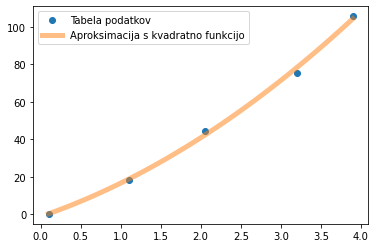

In [52]:
x_g = np.linspace(np.min(x), np.max(x), 100) # več točk za prikaz
plt.plot(x, y, 'o', label='Tabela podatkov')
plt.plot(x_g, apr_polinom(x_g, a), lw=5, alpha=0.5, label='Aproksimacija s kvadratno funkcijo')
plt.legend();

Poglejmo še napako aproksimacije:
$$e_i=y_i - f(x_i)$$

za $i=0,1,2,\dots,n-1$.

Pri pravilno izvedni aproksimaciji je nekaj $e_i$ pozitivnih in nekaj negativnih. Poglejmo, če je to res v našem primeru:

In [53]:
e = y - apr_polinom(x, a)
e

array([-0.06824269, -0.62517387,  2.1057209 , -2.69396374,  1.28165939])

Opomba: višje stopnje polinoma kot uporabimo, večja je verjetnost slabe pogojenosti. Iz tega razloga s stopnjo polinoma ne pretiravamo (v praksi uporabljamo predvsem nizke stopnje)!

## Uporaba `numpy` za aproksimacjo s polinomom

Poglejmo si, kako uporabimo knjižnico `numpy` za polinomsko aproksimacijo. 

Najprej uporabimo funkcijo `numpy.polyfit` ([dokumentacija](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html)):

```python
polyfit(x, y, deg, rcond=None, full=False, w=None, cov=False)
```

ki zahteva tri parametre: `x` in `y` predstavljata tabelo podatkov (lahko tudi v obliki seznamov vektorjev), `deg` pa stopnjo polinoma. Ostali parametri so opcijski (npr. `w` za uporabo uteži pri aproksimaciji). 

Funkcija `polyfit` vrne seznam koeficientov polinoma (najprej za najvišji red); rezultat je lahko tudi seznam seznamov (če so vhodni podatki seznam vektorjev).

Poglejmo si uporabo za predhodno obravnavani primer:

In [54]:
koef = np.polyfit(x, y, deg=2)
koef

array([ 3.17760897, 14.67380042, -1.21091344])

In [55]:
a # rezultat lastne implementacije

array([ 3.17760897, 14.67380042, -1.21091344])

Ko imamo koeficiente, lahko ustvarimo objekt polinoma s klicem ``numpy.poly1d`` ([dokumentacija](https://numpy.org/doc/stable/reference/generated/numpy.poly1d.html#numpy.poly1d)):

```python
poly1d(c_or_r, r=False, variable=None)
```

kjer `c_or_r` predstavlja seznam koeficientov polinoma oz. ničle polinoma v primeru, da je `r=True`. Funkcija vrne instanco objekta, s klicem katere lahko izračunamo vrednosti aproksimacijskega polinoma pri `x`, lahko pa izračunamo tudi druge stvari, kot na primer ničle polinoma.

Poglejmo si primer:

In [56]:
p = np.poly1d(koef) # p je instanca objekta poly1d. Aproksimacijo sedaj dobimo z y = p(x).

Izrišimo vrednosti:

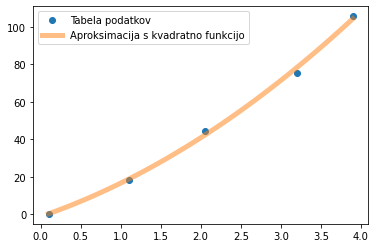

In [57]:
plt.plot(x, y, 'o', label='Tabela podatkov')
plt.plot(x_g, p(x_g), lw=5, alpha=0.5, label='Aproksimacija s kvadratno funkcijo')
plt.legend();

Izračunajmo ničle polinoma:

In [58]:
p.roots

array([-4.69897273,  0.08109792])

# Aproksimacija s poljubno funkcijo

Pri aproksimaciji nismo omejeni zgolj na polinome. Tabele podatkov lahko aproksimiramo:

* z linearno kombinacijo linearno neodvisnih baznih funkcij ali 
* s funkcijo, v kateri nastopajo parametri v nelinearni zvezi (npr. $a_0\,\sin(a_1\,x+a_2)$).

Za podrobnosti glejte vir J. Petrišič: Uvod v Matlab za inženirje, Fakulteta za strojništvo 2013, str 145. 

Osredotočili se bomo na uporabo `scipy` paketa za aproksimacijo z nelinearno fukcijo, ki temelji na metodi najmanjših kvadratov.

## Aproksimacija s harmonsko funkcijo

Tabela podatkov je definirana kot:

In [59]:
x = np.array([ 0.1, 0.8, 1.7, 2.5, 3.4, 4.2,  5.1])
y = np.array([ 0.01, -1.13, 0.02, 0.92, -0.01, -0.98, 0.1])

Prikažimo tabelo podatkov:

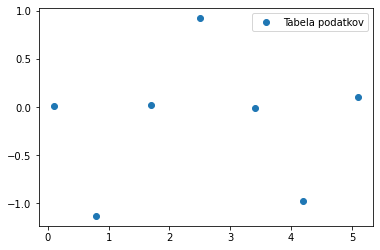

In [60]:
plt.plot(x, y, 'o', label='Tabela podatkov')
plt.legend();

Aproksimacijo z nelinearno funkcijo bomo izvedli s pomočjo ``scipy.optimize.curve_fit`` ([dokumentacija](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)):

```python
curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)
```


katera zahteva tri parametre: `f` predstavlja definicijo Python funkcije, s katero želimo aproksimirati, in katere parametre spreminjamo z uporabo metode najmanjših kvadratov. `xdata` in `ydata` predstavljata tabelo podatkov. Priporočeno je tudi, da definiramo približek iskanih parametrov `p0`. Ostali parametri so opcijski.

Funkcija vrne dve numerični polji: `popt`, ki predstavlja najdene parametre ter `pcov`, ki predstavljajo ocenjeno kovarianco `popt`.

Definirajmo najprej Python funkcijo, katere prvi parameter je neodvisna spremenljivka `x`, nato pa sledijo parametri, ki jih želimo določiti:

In [61]:
def func(x, A, ω, ϕ):
    return A*np.sin(ω*x+ϕ)

kjer je `A` amplitua, `ω` krožna frekvenca in `ϕ` faza harmonske funkcije. S pomočjo slike lahko ugibamo prve približke: `A=1`, `ω=1`, `ϕ=0`

Sedaj uvozimo `curve_fit` in izvedemo optimizacijski postopek:

In [62]:
from scipy.optimize import curve_fit

In [63]:
popt, pcov = curve_fit(func, x, y, p0=[1, 1, 0])
popt

array([ 1.01461945,  1.89652046, -3.27943097])

Izračunali smo pričakovane vrednosti (glejte zgoraj).

In [64]:
func(x, *popt)

array([-0.0525477 , -0.99608783, -0.05612665,  1.00860622, -0.02753942,
       -1.01426499,  0.1110182 ])

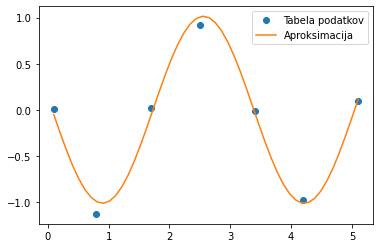

In [65]:
x_g = np.linspace(np.min(x), np.max(x), 50)
y_g = func(x_g, *popt) # bodi pozorni kako smo v funkcijo posredovali parametre
plt.plot(x, y, 'o', label='Tabela podatkov')
plt.plot(x_g, y_g, label='Aproksimacija')
plt.legend();

# Nekaj vprašanj za razmislek!

1. Podatki:
$$x = [-1.00, -0.50, 0.00, 0.50, 1.00]$$
$$y = [−1.00, −0.55, 0.00, 0.45, 1.00]$$
uporabite linearne zlepke in določite prvi odvod.
2. Na zgornjih podatkih izračunajte linearno aproksimacijo ter določite parametra aproksimacije.
3. Na nateznem testu ste testirali aluminijeve vzorce; rezultati testa so podani spodaj.

    Napetost [MPa]:
$$\sigma = [34.5, 69.0, 103.5, 138.0]$$

    Specifična deformacija [mm/m]
$$vzorec_1 = [0.46, 0.95, 1.48, 1.93]$$
$$vzorec_2 = [0.34, 1.02, 1.51, 2.09]$$
$$vzorec_3 = [0.37, 1.00, 1.51, 2.05]$$
    S pomočjo linearne aproksimacije določite elastični modul (napetost/specifična deformacija) vsakega posameznega vzorca.
4. Za vzorce zgoraj linearno aproksimirajte elastični modul čez vse vzorce. Določite tudi standardno napako (glejte ``np.std``).
5. Raziščite pomoč za funkcijo ``np.polyfit`` in utežite različne vzorce z različno utežjo (npr. da prvi meritvi zaupate manj). Izračunajte nato linearno aproksimiran elastični modul.
6. Pojasnite bistvo metode najmanjših kvadratov na primeru linearne aproksimacije. 
7. Podatki:
$$x = [1.0, 2.5, 3.5, 4.0, 1.1, 1.8, 2.2, 3.7]$$
$$y = [6.008, 15.722, 27.130, 33.772, 5.257, 9.549, 11.098, 28.828$$
    Pripravite in pojasnite funkcijo za linearno aproksimacijo.
8. Nadaljujte zgornjo nalogo in z vgrajeno funkcijo ``np.polyfit`` izvedite linearno, kvadratno in kubično polinomsko aproksimacijo. 
9. Nadaljujte zgornjo nalogo in aproksimacije narišite ter določite standarno napako. Katera aproksimacija najbolje popiše podatke?
10. Definirajte polinom 2. ali 3. stopnje. Dodajte šum (enakomeren ``np.random.rand`` ali normalen ``np.random.randn``) ter nato aproksimirajte s polinomom 1., 2. in 3. stopnje. Vse rezultate narišite in jih vrednotite.
11. Podatke iz prejšnje točke aproksimirajte s pomočjo kubičnih zlepkov. Uporabite vgrajeno funkcijo in preučite vpliv parametra `s`.

# Dodatno

Naredite *.exe* svojega programa:

* https://pypi.org/project/py2exe/
* http://www.pyinstaller.org/
* http://pinm.ladisk.si/323/kako-iz-python-kodo-prevedem-v-exe-datoteko

Poglejte [pandas paket](http://pandas.pydata.org/).
<img src="http://pandas.pydata.org/_static/pandas_logo.png">

## Aproksimacija z zlepki in uporabo ``SciPy``

Tabela podatkov naj bo:

In [32]:
x = np.linspace(-3, 3, 20)
x

array([-3.        , -2.68421053, -2.36842105, -2.05263158, -1.73684211,
       -1.42105263, -1.10526316, -0.78947368, -0.47368421, -0.15789474,
        0.15789474,  0.47368421,  0.78947368,  1.10526316,  1.42105263,
        1.73684211,  2.05263158,  2.36842105,  2.68421053,  3.        ])

In [33]:
np.random.seed(0) # seme generatorja naključnih števil
y = np.exp(-x**2) + 0.1 * np.random.normal(scale=.5, size=len(x))
y

array([ 0.08832603,  0.02075073,  0.0526001 ,  0.12684217,  0.14234432,
        0.08387244,  0.34226064,  0.52862107,  0.79385312,  0.99590738,
        0.98257964,  0.87172774,  0.57424082,  0.30083997,  0.15492949,
        0.06565014,  0.08950146, -0.00659471,  0.01639626, -0.04258138])

Poglejmo si objekt ``scipy.interpolate.UnivariateSpline`` ([dokumentacija](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.UnivariateSpline.html)), ki omogoča tako interpolacijo kot aproksimacijo z zlepki:

```python
UnivariateSpline(x, y, w=None, bbox=[None, None], k=3, s=None, ext=0, check_finite=False)
```

Parametra `x` in `y` predstavljata tabelo podatkov. 

Opcijski parameter `s` določa vrednost, katere vsota kvadratov razlik aproksimacijskega zlepka in aproksimacijskih točk ne sme preseči:

```python
sum((w[i] * (y[i]-spl(x[i])))**2, axis=0) <= s
```

`w` so uteži posameznih točk.

Če definiramo `s=0`, zahtevamo interpolacijo. 

Parameter `k` definira stopnjo polinomskega zlepka (privzeto je `k=3`).

Aproksimacijo z zlepki izvedemo tako, da ob tabeli podatkov `x` in `y` definiramo še parameter `s`.  Izvedimo interpolacijo:

In [34]:
from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(x, y, s=0.)

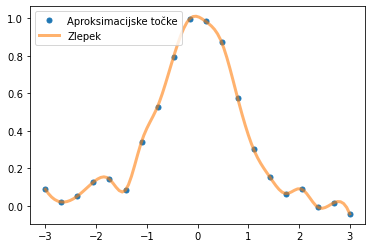

In [35]:
x_g = np.linspace(-3, 3, 100)
plt.plot(x, y, 'o', ms=5, label='Aproksimacijske točke')
plt.plot(x_g, spl(x_g), lw=3, label='Zlepek', alpha=0.6)
plt.legend();

Izvedimo še aproksimacijo:

In [36]:
spl_a = UnivariateSpline(x, y, s=.1)

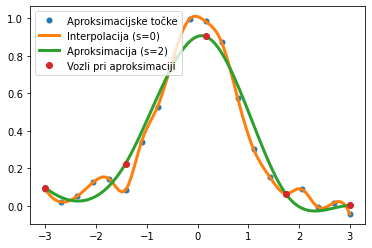

In [37]:
plt.plot(x, y, 'o', ms=5, label='Aproksimacijske točke')
plt.plot(x_g, spl(x_g), lw=3, label='Interpolacija (s=0)');
plt.plot(x_g, spl_a(x_g), lw=3, label='Aproksimacija (s=2)');
plt.plot(spl_a.get_knots(), spl_a(spl_a.get_knots()), 'o', label='Vozli pri aproksimaciji');
plt.legend();

Dejanski preostanek:

In [39]:
spl_a.get_residual()

0.0999987185545532